In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import seaborn as sns
import joblib

In [6]:
df = pd.read_csv("Telco_Cusomer_Churn.csv")

# Fix TotalCharges
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df = df.dropna(subset=["TotalCharges"]).reset_index(drop=True)

# Drop ID column
df = df.drop(columns=["customerID"])

# Target variable
df["Churn_flag"] = df["Churn"].map({"Yes": 1, "No": 0})

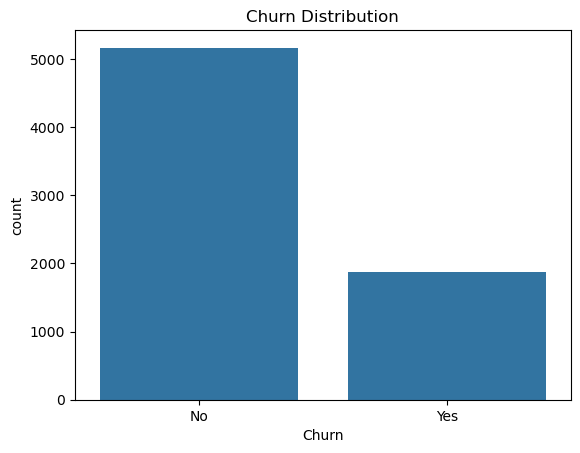

In [7]:
sns.countplot(data=df, x="Churn")
plt.title("Churn Distribution")
plt.show()

In [8]:
pd.crosstab(df["Contract"], df["Churn"], normalize="index") * 100

Churn,No,Yes
Contract,,
Month-to-month,57.290323,42.709677
One year,88.722826,11.277174
Two year,97.151335,2.848665


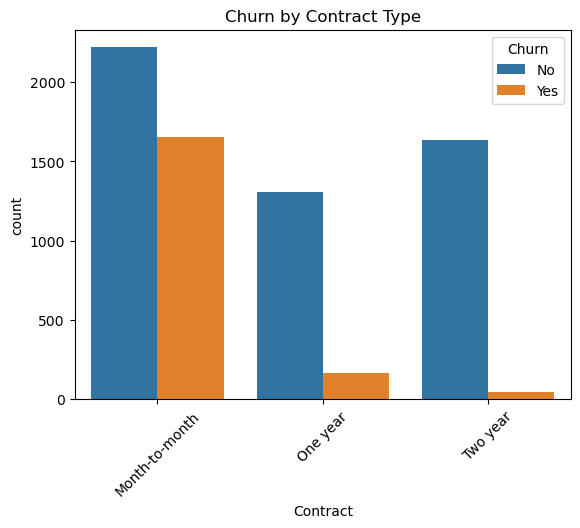

In [9]:
sns.countplot(data=df, x="Contract", hue="Churn")
plt.xticks(rotation=45)
plt.title("Churn by Contract Type")
plt.show()

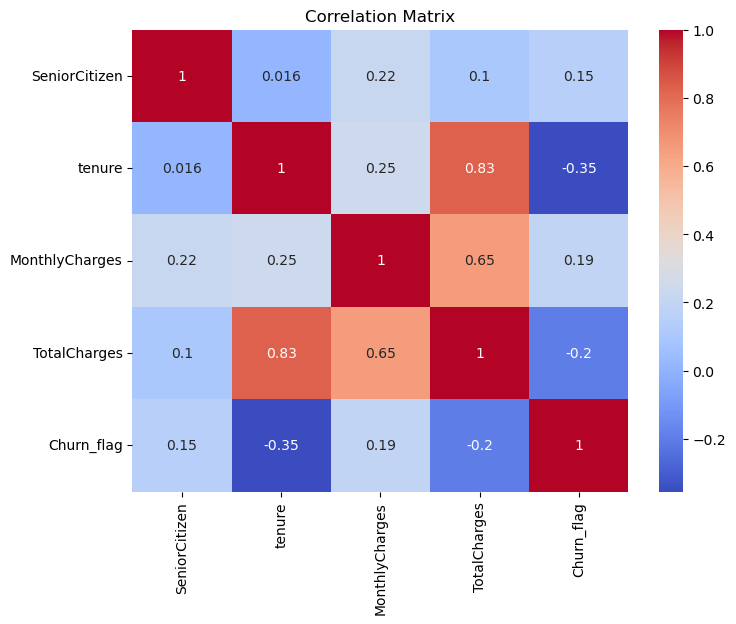

In [10]:
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

In [11]:
X = df.drop(columns=["Churn", "Churn_flag"])
y = df["Churn_flag"]

cat_cols = X.select_dtypes(include=["object"]).columns
num_cols = X.select_dtypes(include=[np.number]).columns

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [12]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", StandardScaler(), num_cols)
    ]
)

In [13]:
log_model = Pipeline([
    ("prep", preprocessor),
    ("clf", LogisticRegression(max_iter=1000))
])

log_model.fit(X_train, y_train)

,steps,"[('prep', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [14]:
rf_model = Pipeline([
    ("prep", preprocessor),
    ("clf", RandomForestClassifier(n_estimators=200, random_state=42))
])

rf_model.fit(X_train, y_train)

,steps,"[('prep', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [15]:
def evaluate(model, name):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]

    print("\n===== ", name, " =====")
    print(classification_report(y_test, y_pred))
    print("ROC-AUC:", roc_auc_score(y_test, y_proba))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

evaluate(log_model, "Logistic Regression")
evaluate(rf_model, "Random Forest")


=====  Logistic Regression  =====
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1033
           1       0.65      0.57      0.61       374

    accuracy                           0.80      1407
   macro avg       0.75      0.73      0.74      1407
weighted avg       0.80      0.80      0.80      1407

ROC-AUC: 0.8359290473207676
Confusion Matrix:
[[917 116]
 [160 214]]

=====  Random Forest  =====
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1033
           1       0.62      0.50      0.55       374

    accuracy                           0.79      1407
   macro avg       0.73      0.69      0.71      1407
weighted avg       0.78      0.79      0.78      1407

ROC-AUC: 0.8109692966335527
Confusion Matrix:
[[921 112]
 [188 186]]


In [16]:
result = permutation_importance(
    rf_model, X_test, y_test, n_repeats=10, random_state=42
)

importances = pd.DataFrame({
    "feature": X.columns,
    "importance": result.importances_mean
}).sort_values("importance", ascending=False)

importances.head(12)

,feature,importance
14,Contract,0.018550
4,tenure,0.017484
18,TotalCharges,0.012225
7,InternetService,0.012082
15,PaperlessBilling,0.009950
11,TechSupport,0.008458
8,OnlineSecurity,0.007605
17,MonthlyCharges,0.006112
13,StreamingMovies,0.005686
16,PaymentMethod,0.005473


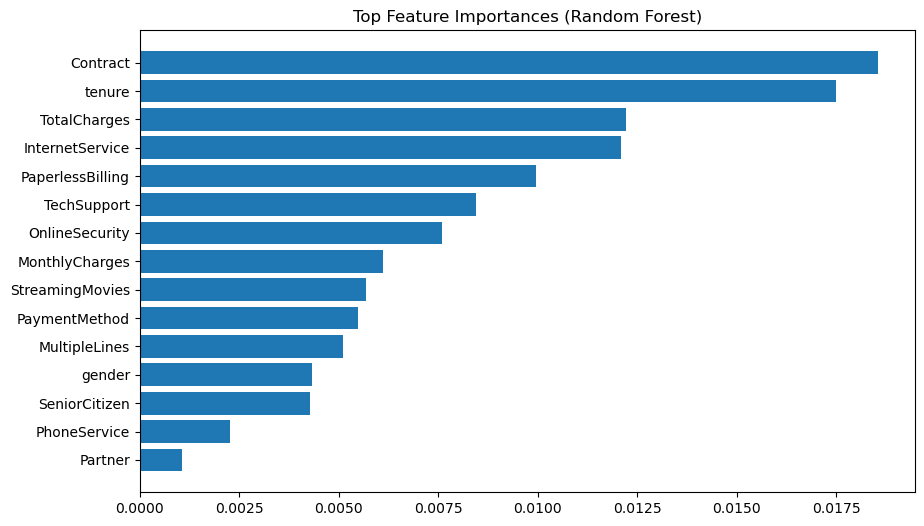

In [17]:
plt.figure(figsize=(10,6))
plt.barh(importances["feature"][:15], importances["importance"][:15])
plt.gca().invert_yaxis()
plt.title("Top Feature Importances (Random Forest)")
plt.show()

In [18]:
joblib.dump(rf_model, "final_churn_model.pkl")
print("Saved: final_churn_model.pkl")

Saved: final_churn_model.pkl


In [19]:
df.to_csv("Telco_Customer_Churn_cleaned.csv", index=False)